## Configuration

In [1]:
from collections import Counter

import pandas as pd

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release"
FANMOD_exe = "LocalFANMOD.exe"

raw_data_folder = './../../data'
raw_data_folder_dataset = '/melanoma_distance_100_XX'
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'
results_dir = './../../results/melanoma_distance_100_XX'
motif_size = 5
iterations = 1000
force_run_fanmod = False
force_parse = False

In [2]:
cells_type = {
    0: 'B cell',
    1: 'CD4 APC',
    2: 'CD4 T cell',
    3: 'CD4 Treg',
    4: 'CD8 T cell',
    5: 'DCs',
    6: 'Germinal Center B cell',
    7: 'Hevs',
    8: 'MAC',
    9: 'Memory CD4 T Cell',
    10: 'NK cell',
    11: 'Neutrophil',
    12: 'Stroma',
    13: 'Tumor',
    14: 'Unidentified',
    15: 'Vessels'
}

Distant_metastases_class = {
    'NP': 'NP',
    'NN': 'NN',
    'PN': 'PN',
    'PP': 'PP',
}

class_to_color = {
    'NP': 'green',
    'NN': 'yellow',
    'PN': 'magenta',
    'PP': 'blue',
}

target_classes = ['NN', 'NP']
target_classes_str = 'NN_NP'

## Steps
1. Initiate CISM object
2. Load datasets
3. Initiate CISMTask

In [19]:
from cism.cism import CISM

In [20]:
cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=raw_data_folder,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)

# adding Melanoma dataset
cism.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=8, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [6]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                                                tissue_state_to_string=Distant_metastases_class,
                                                common_cells_type=cells_type)

In [13]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
NN,20
NP,18
PN,13
PP,17


In [15]:
discriminator.cism.motifs_dataset.groupby('Patient')['ID'].count().describe()

count        68.000000
mean     317588.661765
std      114207.348116
min       57867.000000
25%      235287.500000
50%      292554.000000
75%      374854.000000
max      694551.000000
Name: ID, dtype: float64

## Figure 2
Context-dependent identification of spatial motifs can predict the state of human melanoma disease

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


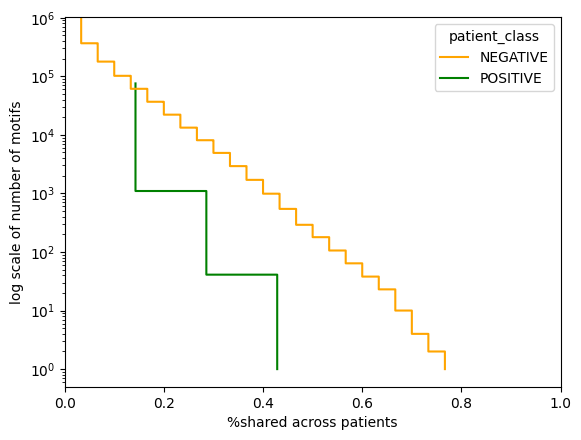

In [8]:
discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=['NEGATIVE', 'POSITIVE'])

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

In [9]:
# export data to excel
discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +'/number_of_motifs_versus_shared_percentage.csv')

### Performance Diagram
1. Pairwise Learning
2. 3 Nodes Motifs
3. 4 Nodes Motifs
4. 5 Nodes Motifs
5. Permutation tests (for threshold 0.46)
6. GNN Performance

Here we export the data for 1, 4, 5


#### Pairwise Learning

In [3]:
#read graphs
from pairwise.reader import GraphReader

full_graph_df = pd.DataFrame()
full_graph_df = GraphReader.get_graphs(full_graph_df=full_graph_df,
                                       raw_data_folder=raw_data_folder,
                                       raw_data_folder_type=raw_data_folder_dataset,
                                       disease='Melanoma',
                                       cells_type=cells_type)

In [7]:
full_graph_df.graph.transform(lambda x: x.number_of_nodes()).describe()

count      177.000000
mean      9183.237288
std       4235.747732
min        189.000000
25%       5281.000000
50%      10660.000000
75%      12385.000000
max      16604.000000
Name: graph, dtype: float64

In [9]:
full_graph_df.graph.transform(lambda x: x.number_of_edges()).describe()

count      177.000000
mean     27379.790960
std      12703.227478
min        390.000000
25%      15702.000000
50%      31828.000000
75%      37015.000000
max      49663.000000
Name: graph, dtype: float64

In [5]:
from pairwise.pairwise_model import PairwiseAnalysis

pairwise_analysis = PairwiseAnalysis(
    tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
    tissue_state_to_string=Distant_metastases_class)

In [10]:
cell_type_counts = pairwise_analysis.get_cell_type_count_from_classes(
                            full_graph_df=full_graph_df,
                            classes=['NN', 'NP','PN'],
                            cells_type=cells_type,
                            normalize=True)
cell_type_counts.to_csv(results_dir +'/NN_NP_PN_cell_type_frequency.csv')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [6]:
group_a_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NN',
                                            cells_type=cells_type)
group_b_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NP',
                                            cells_type=cells_type)

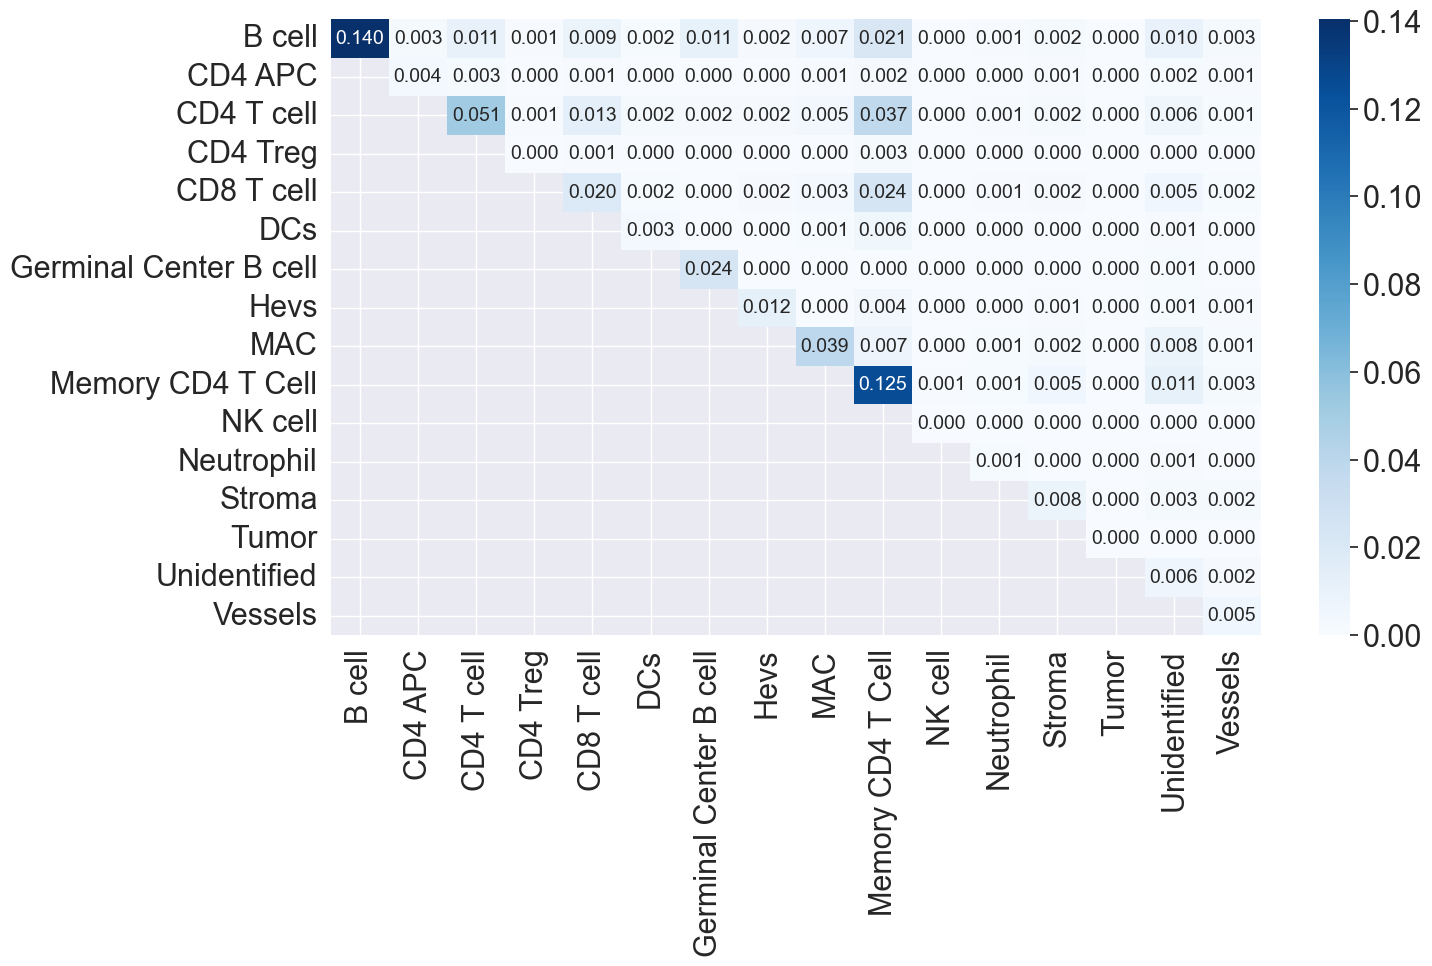

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


plt.figure(figsize=(15,8))

sns.set(font_scale=2)

ax = sns.heatmap(group_a_general_pairwise, annot=True, mask=np.tril(np.ones_like(group_a_general_pairwise), k=-1), cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

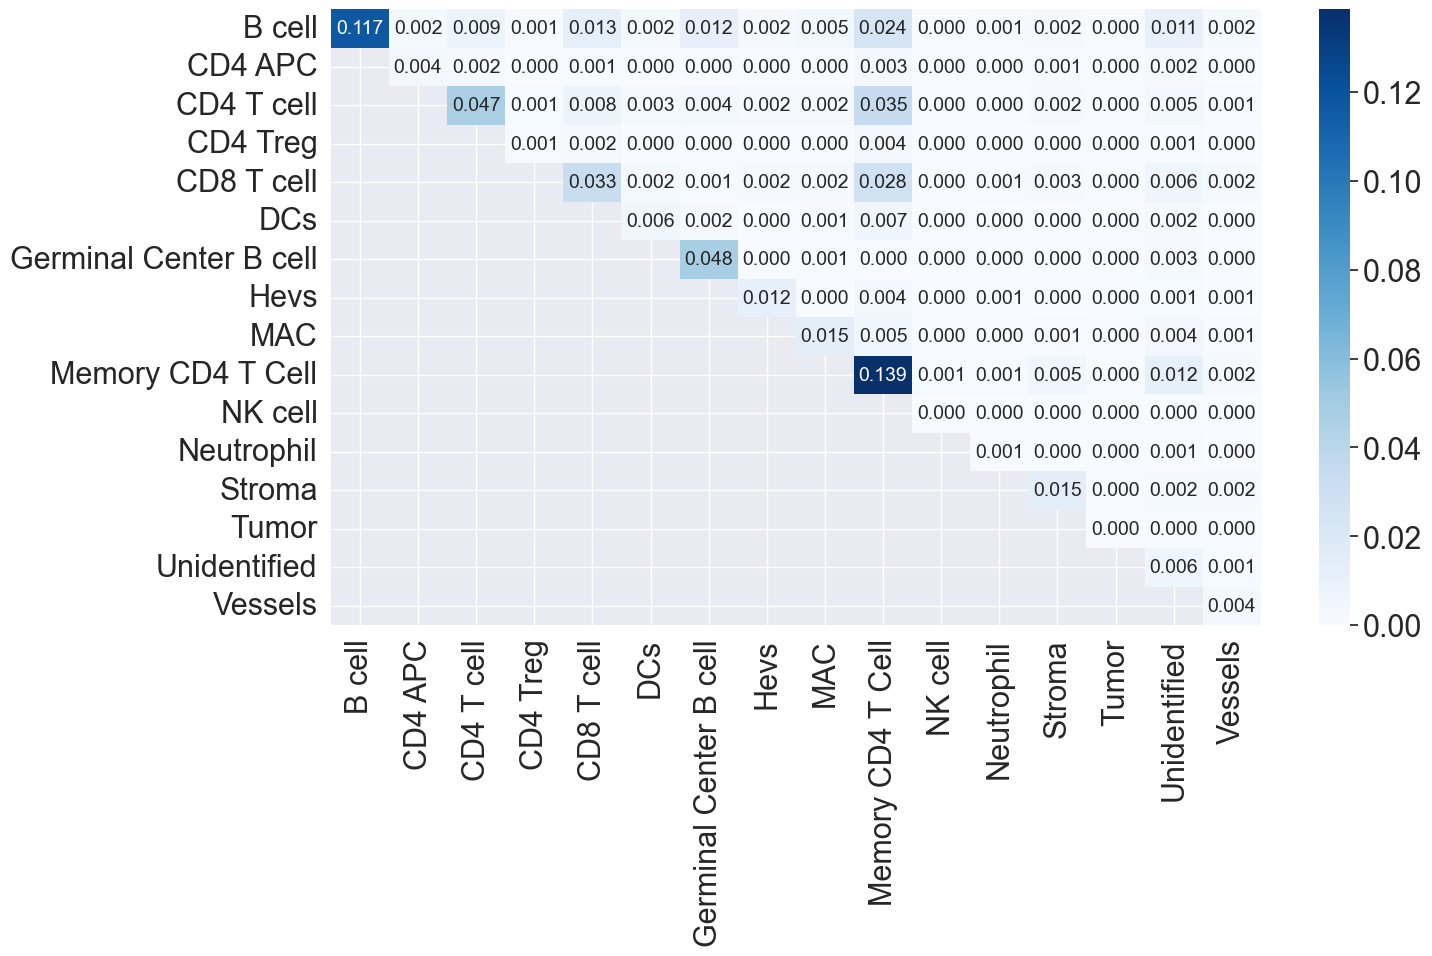

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

ax = sns.heatmap(group_b_general_pairwise, annot=True, mask=np.tril(np.ones_like(group_b_general_pairwise), k=-1), cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [6]:
import numpy as np

roc_auc_scores = pairwise_analysis.analyze(full_graph_df=full_graph_df,
                                           cells_type=cells_type,
                                           labels=['NN', 'NP'],
                                           trials=10)

print(f'roc_auc_score - mean: {np.mean(roc_auc_scores)} std: {np.std(roc_auc_scores)}')

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

roc_auc_score - mean: 0.5655555555555555 std: 0.026779276122211197


#### Motifs 3 Nodes, 4 Nodes

In [4]:
from cism.cism import CISM

local_motif_size = 4

cism_4_nodes = CISM(fanmod_exe=FANMOD_exe,
                    fanmod_path=FANMOD_path,
                    network_dataset_root_path=raw_data_folder,
                    fanmod_output_root_path=output_dir,
                    fanmod_cache_root_path=cache_dir,
                    motif_size=local_motif_size,
                    iterations=iterations)

# adding Melanoma dataset
cism_4_nodes.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=8, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [5]:
from cism.cism import TissueStateDiscriminativeMotifs

discriminator_4_nodes = TissueStateDiscriminativeMotifs(
                            cism=cism_4_nodes,
                            tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                            tissue_state_to_string=Distant_metastases_class,
                            common_cells_type=cells_type)

In [14]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey
from cism.benchmark import DiscriminatorBenchmark

discover_result = discriminator_4_nodes.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=target_classes)

discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/number_of_motifs_{target_classes_str}_{local_motif_size}_nodes_versus_shared_percentage.csv')

Number of Discriminative Motifs Permutation tests - 4 Nodes

In [16]:
perm_result_dict = dict()

In [17]:
from cism.cism import HardDiscriminativeFC

th = 0.5
feature_perm_conf = HardDiscriminativeFC(
                        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                        use_cells_type_composition=False,
                        use_motifs=True,
                        shared_percentage=th,
                        max_class_features=100000,
                        labels=target_classes)

perm_result_dict[th] = [] if perm_result_dict.get(th) is None else perm_result_dict[th]
perm_result_dict[th].extend(discriminator_4_nodes.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=True,
    n_permutations=30,
    n_jobs=2))

  0%|          | 0/30 [00:00<?, ?it/s]

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [18]:
original_motifs_count = discriminator_4_nodes.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=False,
    n_permutations=1,
    n_jobs=1)
original_motifs_count

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

[97]

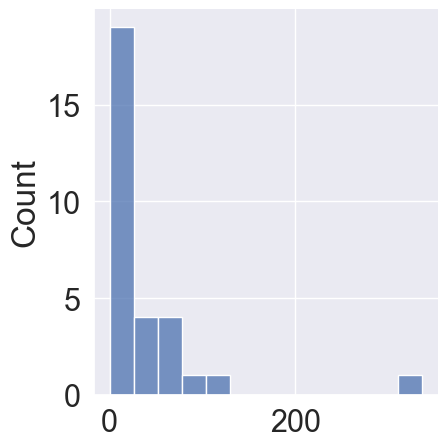

In [19]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [20]:
import numpy as np
np.where(np.array(perm_result_dict[th])>original_motifs_count)

(array([ 4, 22], dtype=int64),)

In [21]:
pd.DataFrame(perm_result_dict[th],columns=[f'th_{th}']).to_csv(results_dir +f'/number_of_motifs_100_{target_classes_str}_{local_motif_size}_permutation.csv')

Permutation of Motifs across Patients (pipeline)

In [ ]:
benchmark_results = None

for th in [0.4]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(0, 100)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator_4_nodes,
                                                    labels=['NN', 'NP'],
                                                    rand_patient_class=False,
                                                    rand_motifs=True,
                                                    benchmark_results=benchmark_results,
                                                    n_jobs=2)

In [ ]:
benchmark_results.to_csv(results_dir +'/' + f'NN_NP_motif_pipeline_{local_motif_size}_benchmark.csv')

Permutation of Patients Classes (pipeline)

In [6]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark
from cism.cism import DiscriminativeFeatureKey

for th in [0.4]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(20, 100)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator_4_nodes,
                                                    labels=target_classes,
                                                    rand_patient_class=True,
                                                    rand_motifs=False,
                                                    benchmark_results=benchmark_results,
                                                    max_class_features=30,
                                                    n_jobs=1)

In [12]:
benchmark_results.to_csv(results_dir +'/' + f'rand_patient_class_pipeline_{target_classes_str}_{"0_40"}_{local_motif_size}_benchmark.csv')

3 Nodes

In [16]:
local_motif_size = 3

cism_3_nodes = CISM(fanmod_exe=FANMOD_exe,
                    fanmod_path=FANMOD_path,
                    network_dataset_root_path=raw_data_folder,
                    fanmod_output_root_path=output_dir,
                    fanmod_cache_root_path=cache_dir,
                    motif_size=local_motif_size,
                    iterations=iterations)

# adding Melanoma dataset
cism_3_nodes.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=12, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [18]:
benchmark_results = None

In [ ]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey
from cism.benchmark import DiscriminatorBenchmark

discriminator_3_nodes = TissueStateDiscriminativeMotifs(
                            cism=cism_3_nodes,
                            tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                            tissue_state_to_string=Distant_metastases_class,
                            common_cells_type=cells_type)

discover_result = discriminator_3_nodes.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=['NP', 'PN'])

discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/number_of_motifs_{local_motif_size}_nodes_versus_shared_percentage.csv')

for th in [0.2, 0.3, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.6, 0.7, 0.72, 0.74, 0.76, 0.8]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(0, 1)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                    labels=['NP', 'PN'],
                                                    rand_patient_class=False,
                                                    benchmark_results=benchmark_results)

benchmark_results.to_csv(results_dir+'/' + f'pipeline_benchmark_{local_motif_size}_nodes.csv')

#### 3 Nodes AUC performance for patient classes permutation

In [22]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark
import numpy as np

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.4,
    trials=list(range(0, 30)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                labels=['NP', 'PN'],
                                                rand_patient_class=True,
                                                benchmark_results=benchmark_results)

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.4,
    trials=list(range(0, 10)))

# run with real classes
benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                labels=['NP', 'PN'],
                                                benchmark_results=benchmark_results)

benchmark_results

In [26]:
benchmark_results.to_csv(results_dir +'/' + f'pipeline_NP_PN_{local_motif_size}_benchmark.csv')

#### Number of Discriminative Motifs Permutation tests

In [26]:
perm_result_dict = dict()

In [ ]:
from cism.cism import HardDiscriminativeFC

th = 0.45
feature_perm_conf = HardDiscriminativeFC(
                        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                        use_cells_type_composition=False,
                        use_motifs=True,
                        shared_percentage=th,
                        max_class_features=100000,
                        labels=['NN', 'NP'])

perm_result_dict[th] = [] if perm_result_dict.get(th) is None else perm_result_dict[th]
perm_result_dict[th].extend(discriminator.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=True,
    n_permutations=100,
    n_jobs=3))

perm_result_dict

In [22]:
original_motifs_count = discriminator.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=False,
    n_permutations=1,
    n_jobs=1)
original_motifs_count

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

[59]

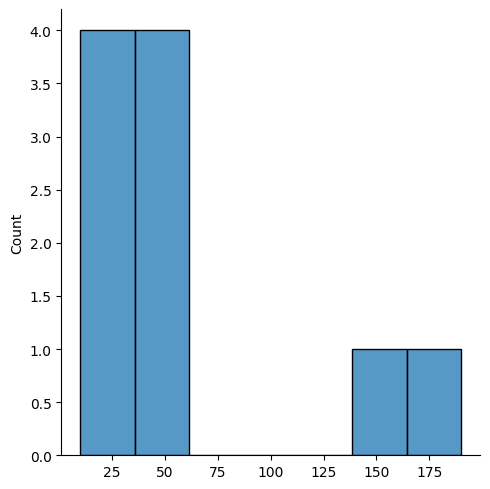

In [23]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [24]:
np.where(np.array(perm_result_dict[th])>original_motifs_count)

(array([1, 8], dtype=int64),)

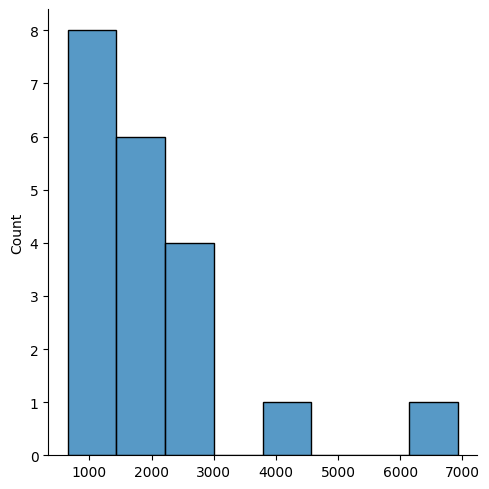

In [14]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [ ]:
2807

## Pipeline Permutation tests

In [6]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark
import numpy as np

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.46,
    trials=list(range(0, 30)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                rand_patient_class=True,
                                                benchmark_results=benchmark_results)

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.46,
    trials=list(range(0, 10)))

# run with real classes
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                benchmark_results=benchmark_results)

benchmark_results

In [8]:
benchmark_results.to_csv(results_dir +'/' + 'NN_NP_pipeline_benchmark.csv')

In [10]:
benchmark_results

## Pipeline randomize the motifs across the dataset

In [6]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark

# run permutation test
discriminator_benchmark = DiscriminatorBenchmark(
                          extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                          shared_percentage=0.46,
                          trials=list(range(0, 100)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                rand_patient_class=False,
                                                rand_motifs=True,
                                                benchmark_results=benchmark_results,
                                                n_jobs=1)

benchmark_results

In [ ]:
benchmark_results.to_csv(results_dir +'/' + 'NN_NP_motif_pipeline_benchmark.csv')

## 4 Nodes
## Within-motif spatial organization contributes to disease state prediction

In [8]:
shared_percentage_th = 0.46

In [9]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(
                    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                    use_cells_type_composition=False,
                    use_motifs=True,
                    shared_percentage=shared_percentage_th,
                    max_class_features=30,
                    labels=['NN', 'NP'])

motif_space_features = discriminator_4_nodes.get_features(feature_conf=featureConf,
                                                          exclude_patients=[],
                                                          n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

FixedFormatter should only be used together with FixedLocator


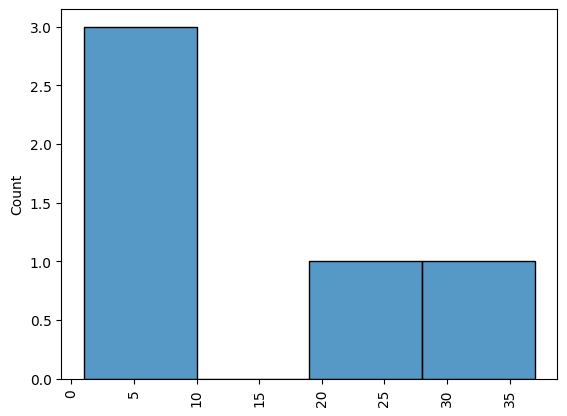

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

counter_across_patients = Counter()
for idx, row in motif_space_features.iterrows():
    counter_across_patients.update(row['features'])

g = sns.histplot(counter_across_patients)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [16]:
optimal_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                      exclude_patients=[],
                                                      n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

In [17]:
optimal_result.get_roc_auc_score()

0.8611111111111112

In [10]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator_4_nodes.cism.motifs_dataset[discriminator_4_nodes.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 19, number of hashes: 19


{12110603532: 2856578561211090970,
 2454267148: -2785496978450312591,
 2961208588: 5322849665145976878,
 15901249932: -2937209521203962343,
 21276842380: 6363102744880394829,
 1672625548: -8334768063605862937,
 1639021836: 7476495471272693903,
 1677351212: -3276004159126218973,
 4880694732: 6501729852448164872,
 16417793484: 7779624149145954569,
 20202011980: 4092891317731859338,
 4071751116: -3224596876564360443,
 3522784716: -7428170179511166437,
 15341317580: 6191483428857422447,
 20748339660: 7522159845133462507,
 11075202540: -2419085700876409031,
 17763644908: -3945035406512623651,
 11561745772: 3341299229835211946,
 11583232364: -3798811191137981739}

In [11]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator_4_nodes.get_patients_class(target_classes)
for motif_id in all_motif_features:
    patients_ids = discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID == motif_id) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == target_classes[0]:
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

In [12]:
from cism import helpers
import networkx as nx
import numpy as np

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            target_motif = helpers.string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += 1

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 1672625548, hash_id: -8334768063605862937
motif_id: 1677351212, hash_id: -3276004159126218973
motif_id: 20202011980, hash_id: 4092891317731859338
motif_id: 20748339660, hash_id: 7522159845133462507
motif_id: 17763644908, hash_id: -3945035406512623651
motif_id: 11561745772, hash_id: 3341299229835211946
motif_id: 11583232364, hash_id: -3798811191137981739


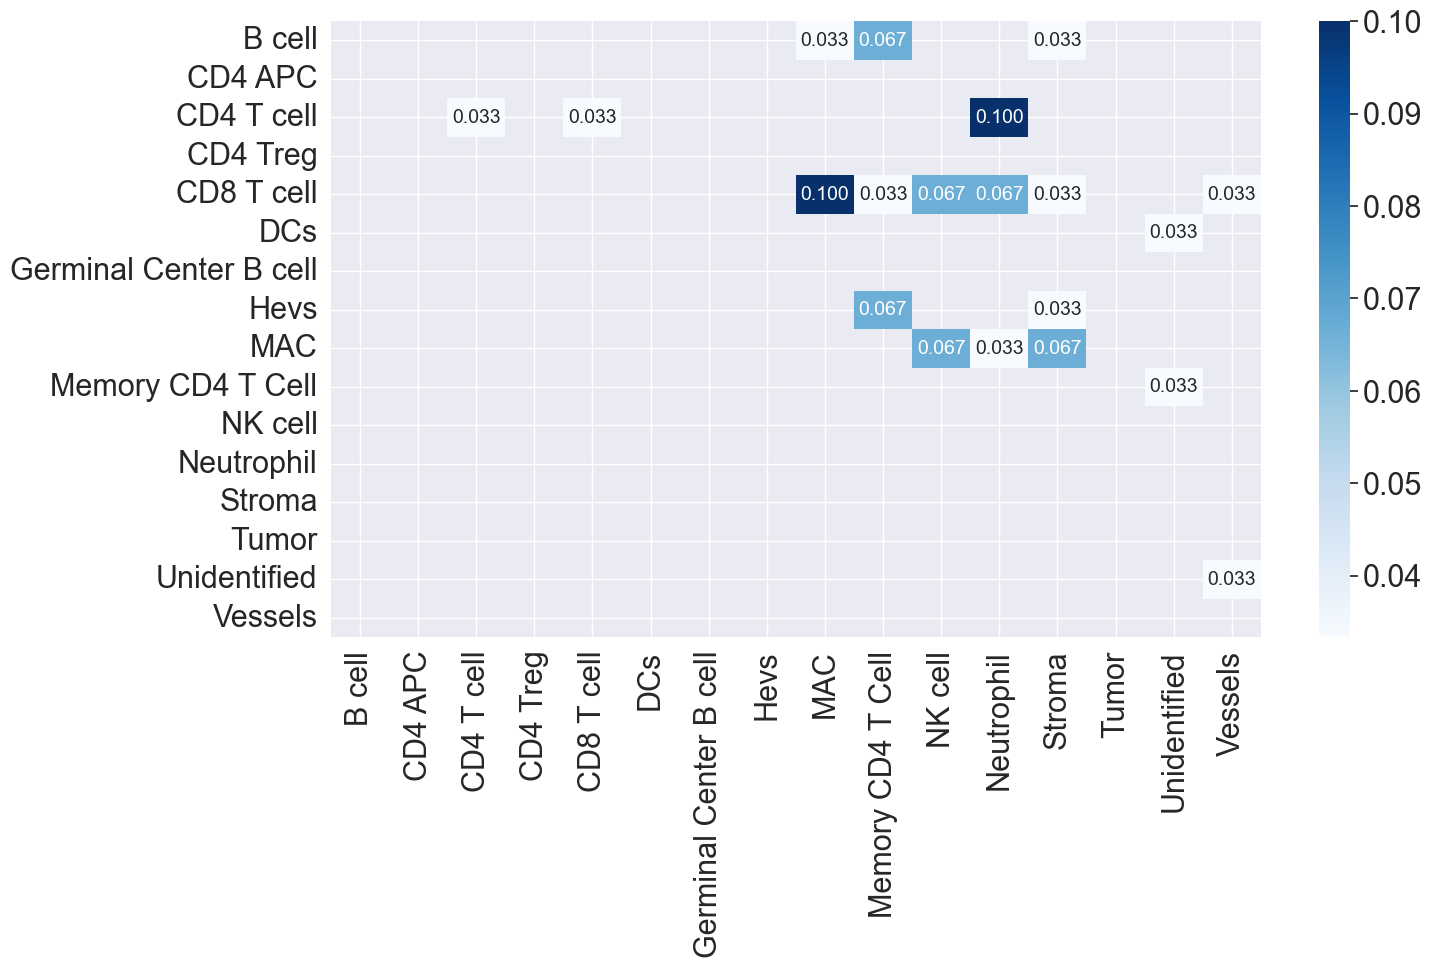

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(discriminator=discriminator_4_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_a_motifs)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

motif_id: 2454267148, hash_id: -2785496978450312591


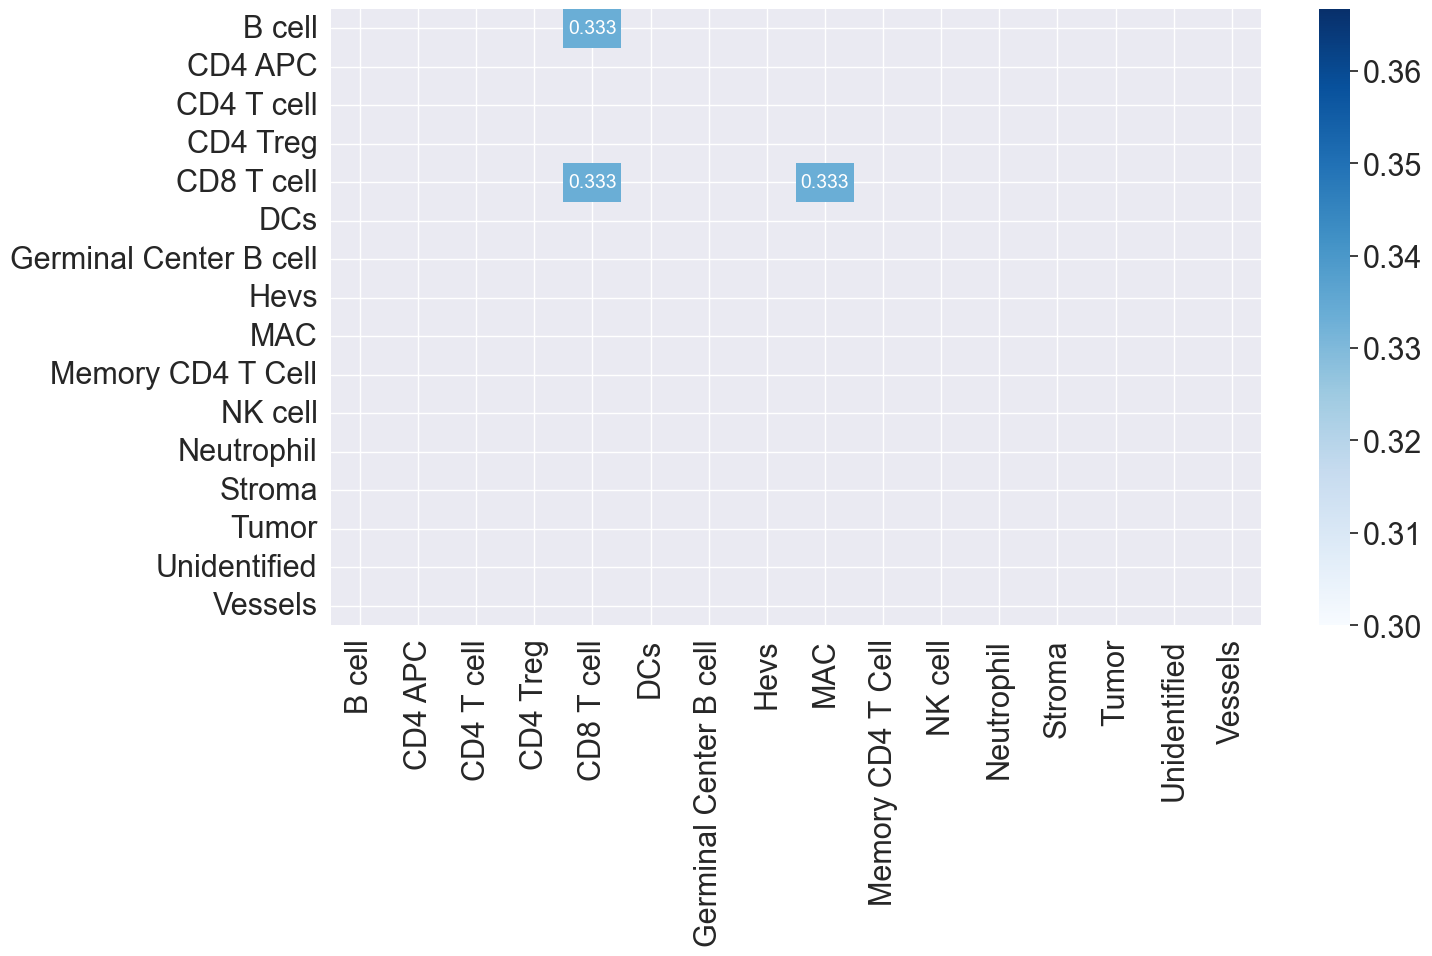

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(discriminator=discriminator_4_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_b_motifs[1:2])

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [57]:
from typing import Union

def switch_ci(motif_space_features: pd.DataFrame,
              target_motif_ids: list,
              motif_to_cells_identity_hash: dict) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id in motif_ids:
            if motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            ci_features.append(motif_to_cells_identity_hash[motif_id])

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

import numpy as np

switch_all_roc_auc_scores = []
for trial in range(10):
    motifs_patient_map, cell_type_composition_patient_map = \
        switch_ci(motif_space_features=motif_space_features,
                  target_motif_ids=[],
                  motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    featureConf = HardDiscriminativeFC(
        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
        use_cells_type_composition=False,
        use_motifs=True,
        shared_percentage=shared_percentage_th,
        max_class_features=10,
        labels=['NN', 'NP'],
        cell_type_composition_patient_map=cell_type_composition_patient_map,
        motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/38 [00:00<?, ?it/s]

0.45555555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

0.4541666666666666


  0%|          | 0/38 [00:00<?, ?it/s]

0.4583333333333333


  0%|          | 0/38 [00:00<?, ?it/s]

0.4736111111111111


  0%|          | 0/38 [00:00<?, ?it/s]

0.45555555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

0.46249999999999997


  0%|          | 0/38 [00:00<?, ?it/s]

0.47500000000000003


  0%|          | 0/38 [00:00<?, ?it/s]

0.4763888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

0.49444444444444446


  0%|          | 0/38 [00:00<?, ?it/s]

0.5055555555555555


0.47111111111111115

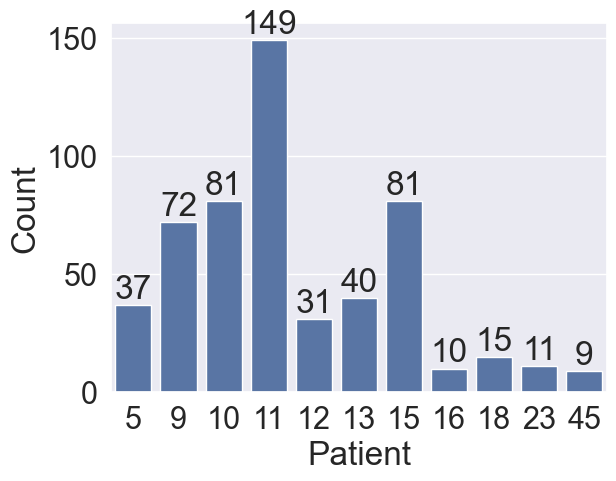

In [80]:
ax = sns.barplot(data=discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID.isin(group_b_motifs[1:2])) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby('Patient')['Count'].sum().reset_index(),
             x='Patient', y='Count')

for i in ax.containers:
    ax.bar_label(i,)

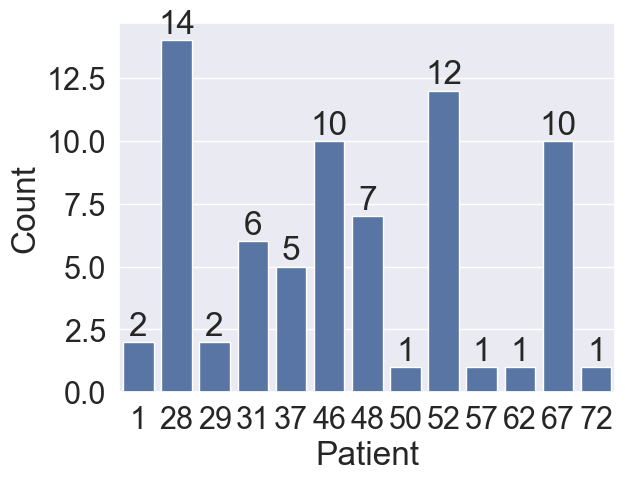

In [82]:
ax = sns.barplot(data=discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID.isin(group_a_motifs)) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby('Patient')['Count'].sum().reset_index(),
             x='Patient', y='Count')

for i in ax.containers:
    ax.bar_label(i,)

In [84]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=10,
            labels=['NN', 'NP'],
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3224596876564360443, roc_auc_score: 0.6888888888888889, roc_auc_ratio: 1.25, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3341299229835211946, roc_auc_score: 0.4458333333333333, roc_auc_ratio: 1.9314641744548289, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2785496978450312591, roc_auc_score: 0.4388888888888889, roc_auc_ratio: 1.9620253164556964, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6191483428857422447, roc_auc_score: 0.7805555555555556, roc_auc_ratio: 1.103202846975089, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6501729852448164872, roc_auc_score: 0.45, roc_auc_ratio: 1.9135802469135803, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
0,-3224596876564360443,0.688889,0.0,[0.6888888888888889],1.250000,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,3341299229835211946,0.445833,0.0,[0.4458333333333333],1.931464,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,-2785496978450312591,0.438889,0.0,[0.4388888888888889],1.962025,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,6191483428857422447,0.780556,0.0,[0.7805555555555556],1.103203,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6501729852448164872,0.450000,0.0,[0.45],1.913580,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


In [85]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
3,6191483428857422447,0.780556,0.0,[0.7805555555555556],1.103203,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
0,-3224596876564360443,0.688889,0.0,[0.6888888888888889],1.250000,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6501729852448164872,0.450000,0.0,[0.45],1.913580,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,3341299229835211946,0.445833,0.0,[0.4458333333333333],1.931464,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,-2785496978450312591,0.438889,0.0,[0.4388888888888889],1.962025,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


(16, 5)


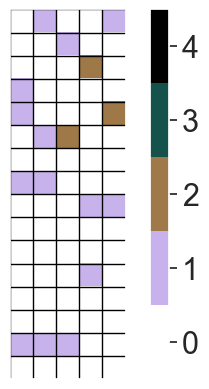

In [88]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = matplotlib.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_colors_bar(discriminator,
                    ratio_gain_results: pd.DataFrame,
                    cells_type: dict):
    colors_data = None
    count = 0
    for idx, row in ratio_gain_results.iterrows():
        colors_vec_hash = row['hash']
        colors_vec = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.colors_vec_hash == colors_vec_hash].iloc[0].colors_vec
        count += len(colors_vec)
        if colors_data is None:
            colors_data = np.array(colors_vec)
        else:
            colors_data = np.append(colors_data, colors_vec)

    colors_data = colors_data.reshape(ratio_gain_results.shape[0], len(cells_type))
    colors_data = colors_data.transpose()
    print(colors_data.shape)
    number_of_colors = 5
    plt.grid(visible=True, color='black', linestyle='-', linewidth=1)
    plt.imshow(colors_data, cmap=discrete_cmap(number_of_colors, 'cubehelix_r'), vmin=0, vmax=number_of_colors)
    plt.colorbar(ticks=range(number_of_colors))
    plt.clim(-0.5, number_of_colors - 0.5)
    plt.xticks(np.arange(-.5, ratio_gain_results.shape[0]-1, 1), labels=[])
    plt.yticks(ticks=np.arange(-.5, len(cells_type)-1, 1), labels=[])
    plt.show()

plot_colors_bar(discriminator_4_nodes, ratio_gain_results, cells_type)

## 5 Nodes
## Within-motif spatial organization contributes to disease state prediction

In [7]:
from cism.cism import DiscriminativeFeatureKey

discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=target_classes)

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

NameError: name 'discriminator' is not defined

In [14]:
shared_percentage_th = 0.46

In [17]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                   use_cells_type_composition=False,
                                   use_motifs=True,
                                   shared_percentage=shared_percentage_th,
                                   max_class_features=30,
                                   labels=target_classes)

motif_space_features = discriminator.get_features(feature_conf=featureConf,
                                                  exclude_patients=[],
                                                  n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

In [18]:
optimal_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                              exclude_patients=[],
                                              n_jobs=1)
optimal_result.get_roc_auc_score()

  0%|          | 0/38 [00:00<?, ?it/s]

0.7708333333333334

In [19]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 146, number of hashes: 117


{83642523355532: 6242340426492488716,
 313664966330764: 9061201570180626681,
 297163709293004: 7710208002406967212,
 288374060818892: 7710208002406967212,
 164136852344300: 4411254575308607775,
 128784842136012: 8566408388841294084,
 56377103098220: -5768768028389362545,
 81512291869036: 1068795552753912421,
 170719850128844: -862821480751832789,
 95950949705164: -2945146220698803705,
 205782822381004: -4782720867743686861,
 72869878326732: -6156726853842114698,
 6761510790604: 868163481621610569,
 154187587850732: -3473612204745480376,
 307081965430220: -7878447293172999338,
 124753174530508: -9032467371395819727,
 81530502457804: -2589755919613459239,
 292765666978252: 7710208002406967212,
 143238512323020: 1655833470991613645,
 81649806453196: -2945146220698803705,
 100135294314956: -5255296191909951618,
 85851342481868: -5067187399885985459,
 25434945432012: -5562288200077420028,
 95726530325964: -5255296191909951618,
 104739503500748: -1110891335820827131,
 95803841867212: -370135

In [20]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator.get_patients_class(target_classes)
for motif_id in all_motif_features:
    patients_ids = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID == motif_id) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == target_classes[0]:
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

motif_id: 313664966330764, hash_id: 9061201570180626681
motif_id: 283980287291788, hash_id: 9061201570180626681
motif_id: 297163709293004, hash_id: 7710208002406967212
motif_id: 288374060818892, hash_id: 7710208002406967212
motif_id: 292765666978252, hash_id: 7710208002406967212
motif_id: 294964694419916, hash_id: 7710208002406967212
motif_id: 286179332526540, hash_id: 7710208002406967212
motif_id: 315863981171148, hash_id: 7710208002406967212
motif_id: 164136852344300, hash_id: 4411254575308607775
motif_id: 56377103098220, hash_id: -5768768028389362545
motif_id: 81512291869036, hash_id: 1068795552753912421
motif_id: 170719850128844, hash_id: -862821480751832789
motif_id: 166319660310988, hash_id: -862821480751832789
motif_id: 95950949705164, hash_id: -2945146220698803705
motif_id: 81649806453196, hash_id: -2945146220698803705
motif_id: 89366771129804, hash_id: -2945146220698803705
motif_id: 72869878326732, hash_id: -6156726853842114698
motif_id: 154187587850732, hash_id: -347361220474

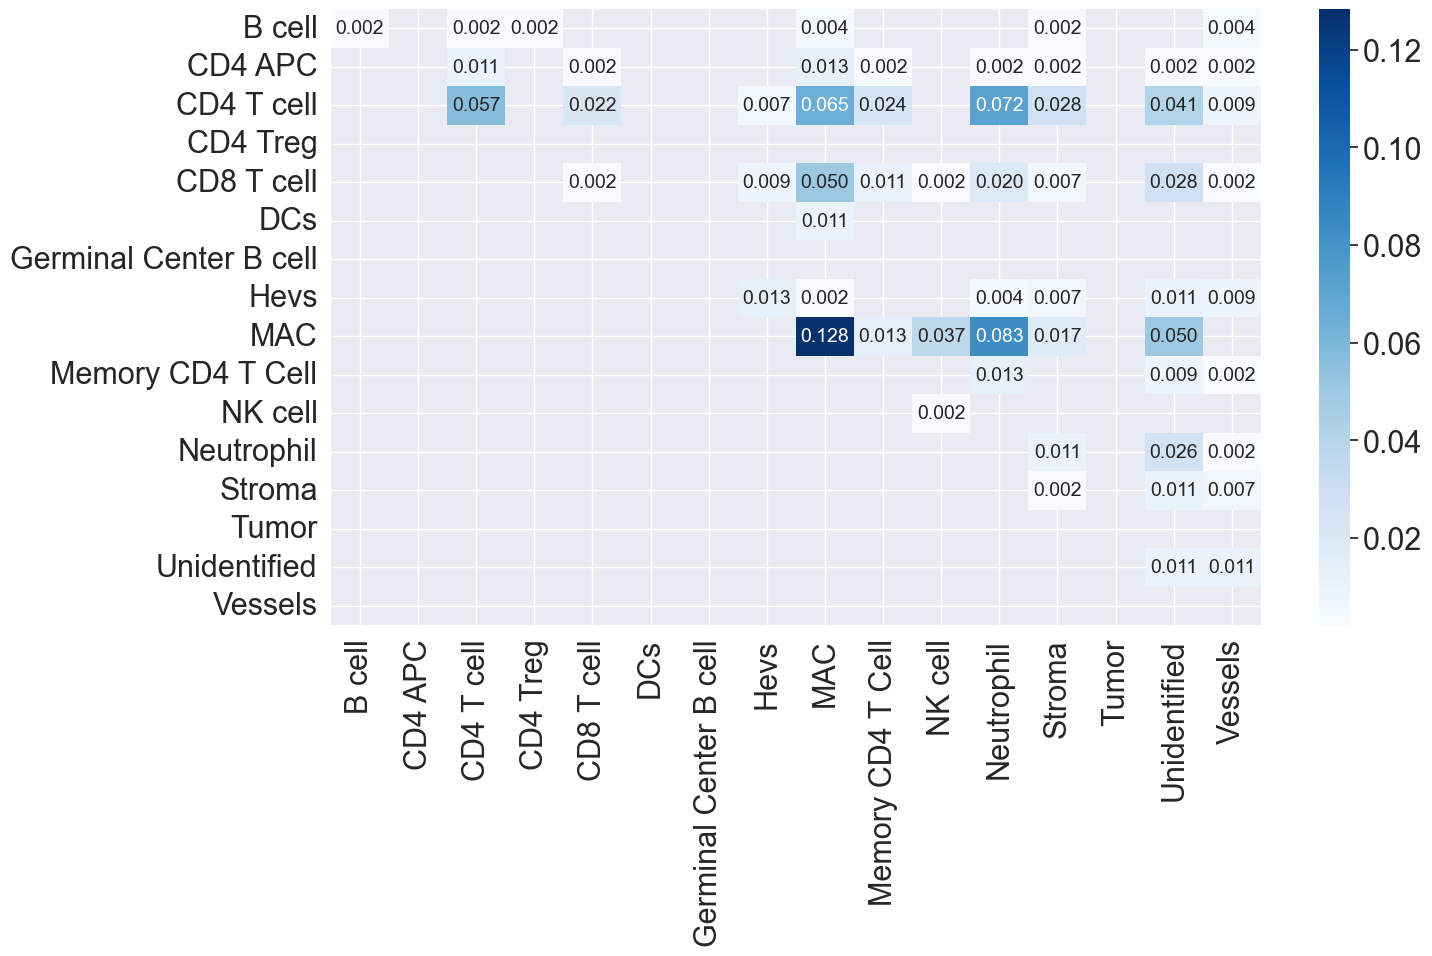

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
from cism import helpers

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = helpers.create_weight_matrix_from_motifs(discriminator=discriminator,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_a_motifs)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

motif_id: 83642523355532, hash_id: 6242340426492488716
motif_id: 128784842136012, hash_id: 8566408388841294084
motif_id: 205782822381004, hash_id: -4782720867743686861
motif_id: 6761510790604, hash_id: 868163481621610569
motif_id: 124753174530508, hash_id: -9032467371395819727
motif_id: 133524587236812, hash_id: -9032467371395819727
motif_id: 81530502457804, hash_id: -2589755919613459239
motif_id: 25434945432012, hash_id: -5562288200077420028
motif_id: 23274619867596, hash_id: -4765929989413547198
motif_id: 2402148364748, hash_id: -4765929989413547198
motif_id: 23270333286860, hash_id: -4765929989413547198
motif_id: 46469703053772, hash_id: -3386606129487089404
motif_id: 34091475349964, hash_id: 6915922370126081657
motif_id: 15413568315884, hash_id: 3088789774869567602
motif_id: 126547077015724, hash_id: 5221027578939539712
motif_id: 29865316432332, hash_id: -6189231459023983361
motif_id: 34233195307212, hash_id: -2957599920391936243
motif_id: 145304270803148, hash_id: 4700860425482556

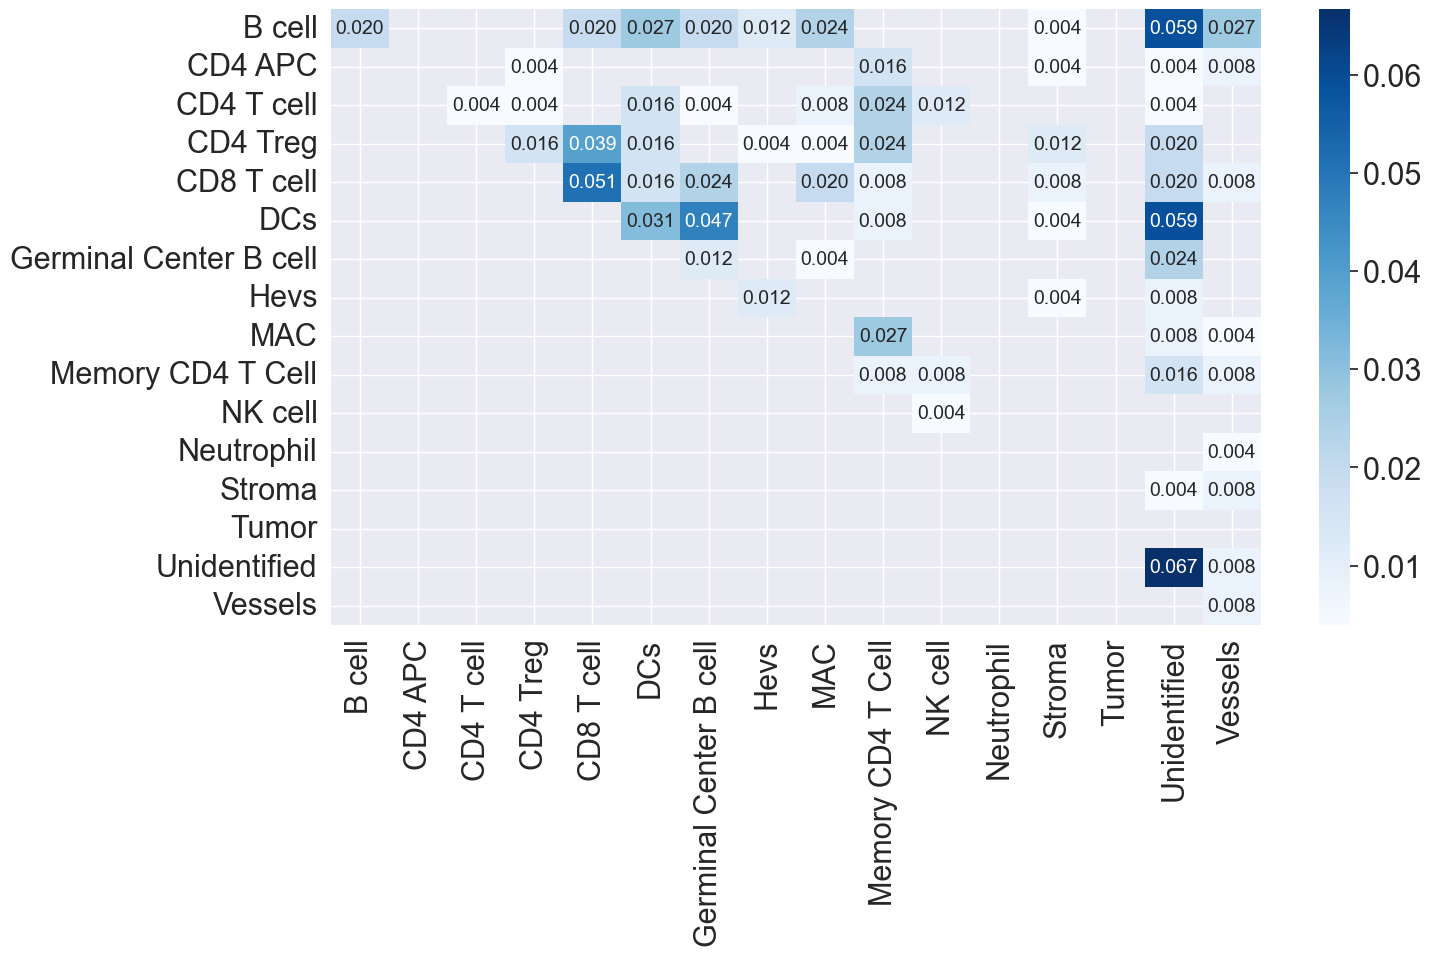

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = helpers.create_weight_matrix_from_motifs(discriminator=discriminator,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_b_motifs)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [22]:
def switch_ci(motif_space_features: pd.DataFrame,
              target_motif_ids: list,
              motif_to_cells_identity_hash: dict) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id in motif_ids:
            if motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            ci_features.append(motif_to_cells_identity_hash[motif_id])

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

In [30]:
def switch_all(motif_to_cells_identity_hash: dict,
                   target_motif_ids: list,
               include_all_motifs: bool,
               include_all_cell_identity: bool) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id, cell_identity_hash in motif_to_cells_identity_hash.items():
            if target_motif_ids is not None and motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            if include_all_cell_identity:
                ci_features.append(cell_identity_hash)

            if target_motif_ids is None and include_all_motifs:
                motifs_features.append(motif_id)

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

In [34]:
motif_to_cells_identity_hash

{12110603532: 2856578561211090970,
 2454267148: -2785496978450312591,
 2961208588: 5322849665145976878,
 15901249932: -2937209521203962343,
 21276842380: 6363102744880394829,
 1672625548: -8334768063605862937,
 1639021836: 7476495471272693903,
 1677351212: -3276004159126218973,
 4880694732: 6501729852448164872,
 16417793484: 7779624149145954569,
 20202011980: 4092891317731859338,
 4071751116: -3224596876564360443,
 3522784716: -7428170179511166437,
 15341317580: 6191483428857422447,
 20748339660: 7522159845133462507,
 11075202540: -2419085700876409031,
 17763644908: -3945035406512623651,
 11561745772: 3341299229835211946,
 11583232364: -3798811191137981739}

In [41]:
for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_all(motif_to_cells_identity_hash=motif_to_cells_identity_hash,
                       target_motif_ids=motif_ids,
                       include_all_motifs=False,
                       include_all_cell_identity=True)

    featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=30,
            labels=target_classes,
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

    new_switch_all = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                              exclude_patients=[],
                                              n_jobs=1,
                                              random_state=np.random.RandomState(trial))

    print(f'motifs: {motif_ids} hash:{hash}, auc:{new_switch_all.get_roc_auc_score()}')

  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [12110603532] hash:2856578561211090970, auc:0.6708333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [2454267148] hash:-2785496978450312591, auc:0.6861111111111111


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [2961208588] hash:5322849665145976878, auc:0.6708333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [15901249932] hash:-2937209521203962343, auc:0.7208333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [21276842380] hash:6363102744880394829, auc:0.7166666666666667


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [1672625548] hash:-8334768063605862937, auc:0.7013888888888888


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [1639021836] hash:7476495471272693903, auc:0.7027777777777778


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [1677351212] hash:-3276004159126218973, auc:0.7749999999999999


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [4880694732] hash:6501729852448164872, auc:0.8097222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [16417793484] hash:7779624149145954569, auc:0.6597222222222223


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [20202011980] hash:4092891317731859338, auc:0.6430555555555556


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [4071751116] hash:-3224596876564360443, auc:0.7847222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [3522784716] hash:-7428170179511166437, auc:0.7527777777777778


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [15341317580] hash:6191483428857422447, auc:0.7541666666666667


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [20748339660] hash:7522159845133462507, auc:0.6625000000000001


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [11075202540] hash:-2419085700876409031, auc:0.7027777777777777


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [17763644908] hash:-3945035406512623651, auc:0.6958333333333333


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [11561745772] hash:3341299229835211946, auc:0.6416666666666666


  0%|          | 0/38 [00:00<?, ?it/s]

motifs: [11583232364] hash:-3798811191137981739, auc:0.6736111111111112


In [36]:
new_switch_all.get_roc_auc_score()

0.6861111111111111

In [33]:
new_switch_all.get_roc_auc_score()

0.6347222222222222

In [23]:
from typing import Union
import numpy as np

switch_all_roc_auc_scores = []
for trial in range(1):
    motifs_patient_map, cell_type_composition_patient_map = \
        switch_ci(motif_space_features=motif_space_features,
                  target_motif_ids=[],
                  motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    featureConf = HardDiscriminativeFC(
        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
        use_cells_type_composition=False,
        use_motifs=True,
        shared_percentage=shared_percentage_th,
        max_class_features=30,
        labels=target_classes,
        cell_type_composition_patient_map=cell_type_composition_patient_map,
        motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                                     exclude_patients=[],
                                                     n_jobs=1,
                                                     random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/38 [00:00<?, ?it/s]

0.5625


0.5625

In [25]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if hash != -2785496978450312591:
        continue

    print(hash)

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    print(motifs_patient_map)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=30,
            labels=target_classes,
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

-2785496978450312591
{'Melanoma1': [], 'Melanoma10': [], 'Melanoma11': [], 'Melanoma12': [], 'Melanoma13': [], 'Melanoma14': [], 'Melanoma15': [], 'Melanoma16': [], 'Melanoma18': [], 'Melanoma19': [], 'Melanoma2': [], 'Melanoma20': [], 'Melanoma22': [], 'Melanoma23': [], 'Melanoma28': [], 'Melanoma29': [], 'Melanoma3': [], 'Melanoma31': [], 'Melanoma32': [], 'Melanoma33': [], 'Melanoma35': [], 'Melanoma37': [], 'Melanoma4': [], 'Melanoma40': [], 'Melanoma44': [], 'Melanoma45': [2454267148], 'Melanoma46': [], 'Melanoma47': [], 'Melanoma48': [], 'Melanoma5': [], 'Melanoma50': [], 'Melanoma52': [], 'Melanoma57': [], 'Melanoma62': [], 'Melanoma67': [], 'Melanoma72': [], 'Melanoma8': [], 'Melanoma9': []}


  0%|          | 0/38 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if hash is not -2785496978450312591:
        continue

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=30,
            labels=target_classes,
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

  0%|          | 0/38 [00:00<?, ?it/s]

hash: 2856578561211090970, roc_auc_score: 0.3902777777777778, roc_auc_ratio: 2.2775800711743774, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2785496978450312591, roc_auc_score: 0.37916666666666665, roc_auc_ratio: 2.3443223443223444, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 5322849665145976878, roc_auc_score: 0.37916666666666665, roc_auc_ratio: 2.3443223443223444, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2937209521203962343, roc_auc_score: 0.37916666666666665, roc_auc_ratio: 2.3443223443223444, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6363102744880394829, roc_auc_score: 0.6708333333333333, roc_auc_ratio: 1.3250517598343687, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8334768063605862937, roc_auc_score: 0.3930555555555556, roc_auc_ratio: 2.2614840989399294, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7476495471272693903, roc_auc_score: 0.3875, roc_auc_ratio: 2.293906810035842, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3276004159126218973, roc_auc_score: 0.38333333333333336, roc_auc_ratio: 2.318840579710145, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6501729852448164872, roc_auc_score: 0.37916666666666665, roc_auc_ratio: 2.3443223443223444, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7779624149145954569, roc_auc_score: 0.325, roc_auc_ratio: 2.735042735042735, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4092891317731859338, roc_auc_score: 0.39583333333333337, roc_auc_ratio: 2.245614035087719, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3224596876564360443, roc_auc_score: 0.7305555555555556, roc_auc_ratio: 1.2167300380228137, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7428170179511166437, roc_auc_score: 0.55, roc_auc_ratio: 1.6161616161616161, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6191483428857422447, roc_auc_score: 0.6763888888888888, roc_auc_ratio: 1.3141683778234088, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7522159845133462507, roc_auc_score: 0.3777777777777778, roc_auc_ratio: 2.3529411764705883, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2419085700876409031, roc_auc_score: 0.37916666666666665, roc_auc_ratio: 2.3443223443223444, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3945035406512623651, roc_auc_score: 0.37916666666666665, roc_auc_ratio: 2.3443223443223444, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3341299229835211946, roc_auc_score: 0.3930555555555556, roc_auc_ratio: 2.2614840989399294, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3798811191137981739, roc_auc_score: 0.3833333333333333, roc_auc_ratio: 2.3188405797101455, avg features: 4.894736842105263, std features: 0.92384255369158, number of mapped features: 1


,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
0,2856578561211090970,0.390278,0.0,[0.3902777777777778],2.277580,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,-2785496978450312591,0.379167,0.0,[0.37916666666666665],2.344322,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,5322849665145976878,0.379167,0.0,[0.37916666666666665],2.344322,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,-2937209521203962343,0.379167,0.0,[0.37916666666666665],2.344322,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6363102744880394829,0.670833,0.0,[0.6708333333333333],1.325052,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
5,-8334768063605862937,0.393056,0.0,[0.3930555555555556],2.261484,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
6,7476495471272693903,0.387500,0.0,[0.3875],2.293907,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
7,-3276004159126218973,0.383333,0.0,[0.38333333333333336],2.318841,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
8,6501729852448164872,0.379167,0.0,[0.37916666666666665],2.344322,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
9,7779624149145954569,0.325000,0.0,[0.325],2.735043,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


In [34]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
11,-3224596876564360443,0.730556,0.0,[0.7305555555555556],1.216730,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
13,6191483428857422447,0.676389,0.0,[0.6763888888888888],1.314168,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6363102744880394829,0.670833,0.0,[0.6708333333333333],1.325052,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
12,-7428170179511166437,0.550000,0.0,[0.55],1.616162,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
10,4092891317731859338,0.395833,0.0,[0.39583333333333337],2.245614,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
17,3341299229835211946,0.393056,0.0,[0.3930555555555556],2.261484,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
5,-8334768063605862937,0.393056,0.0,[0.3930555555555556],2.261484,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
0,2856578561211090970,0.390278,0.0,[0.3902777777777778],2.277580,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
6,7476495471272693903,0.387500,0.0,[0.3875],2.293907,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
7,-3276004159126218973,0.383333,0.0,[0.38333333333333336],2.318841,4.894737,0.923843,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


(16, 19)


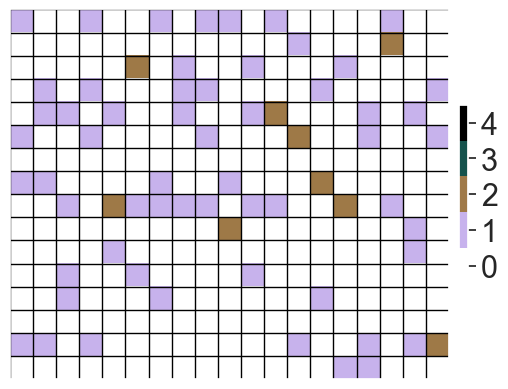

In [35]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = matplotlib.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_colors_bar(discriminator,
                    ratio_gain_results: pd.DataFrame,
                    cells_type: dict):
    colors_data = None
    count = 0
    for idx, row in ratio_gain_results.iterrows():
        colors_vec_hash = row['hash']
        colors_vec = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.colors_vec_hash == colors_vec_hash].iloc[0].colors_vec
        count += len(colors_vec)
        if colors_data is None:
            colors_data = np.array(colors_vec)
        else:
            colors_data = np.append(colors_data, colors_vec)

    colors_data = colors_data.reshape(ratio_gain_results.shape[0], len(cells_type))
    colors_data = colors_data.transpose()
    print(colors_data.shape)
    number_of_colors = 5
    plt.grid(visible=True, color='black', linestyle='-', linewidth=1)
    plt.imshow(colors_data, cmap=discrete_cmap(number_of_colors, 'cubehelix_r'), vmin=0, vmax=number_of_colors)
    plt.colorbar(ticks=range(number_of_colors), fraction=0.018, pad=0.02)
    plt.clim(-0.5, number_of_colors - 0.5)
    plt.xticks(np.arange(-.5, ratio_gain_results.shape[0]-1, 1), labels=[])
    plt.yticks(ticks=np.arange(-.5, len(cells_type)-1, 1), labels=[])
    plt.show()

plot_colors_bar(discriminator_4_nodes, ratio_gain_results, cells_type)

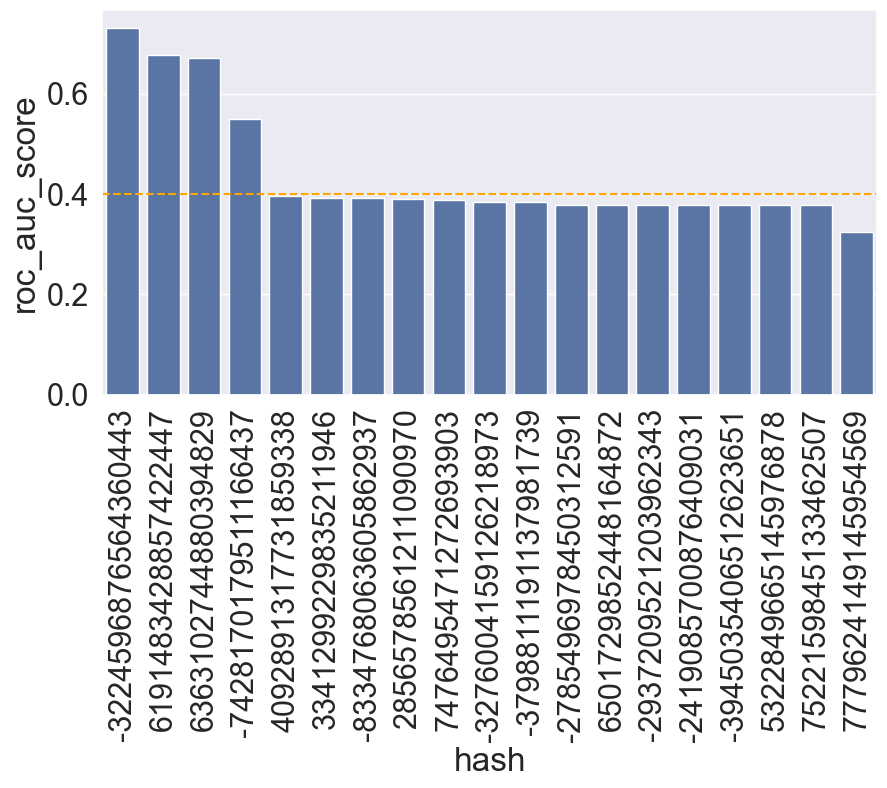

In [36]:
import seaborn as sns
plt.figure(figsize=(10,5))
g = sns.barplot(ratio_gain_results, x='hash', y='roc_auc_score', order=ratio_gain_results['hash'])
plt.xticks(rotation=90)
g.axhline(np.mean(switch_all_roc_auc_scores), ls='--', color='orange', ms='50')

In [37]:
ratio_gain_results.to_csv(results_dir +'/' + f'ratio_gain_{target_classes_str}_{local_motif_size}_results.csv' )

In [38]:
discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID', 'colors_vec_hash'], observed=True)['Count'].sum().reset_index().to_csv(results_dir +'/' + f'{target_classes_str}_{local_motif_size}_motifs_counts_across_patients.csv')

motif_id: 4071751116, hash_id: -3224596876564360443


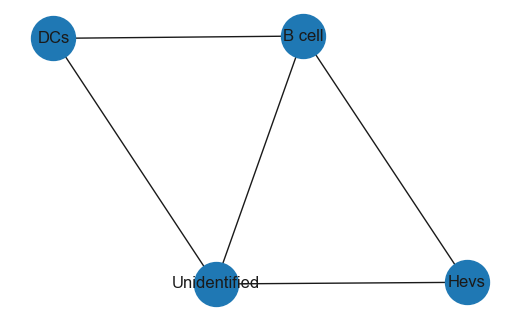

motif_id: 15341317580, hash_id: 6191483428857422447


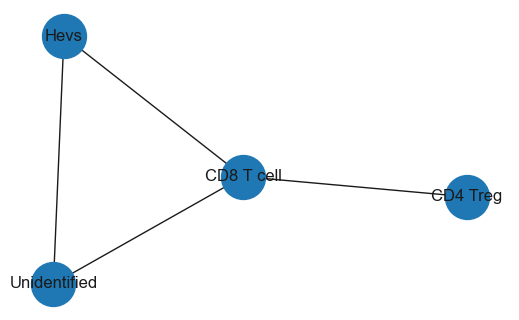

motif_id: 21276842380, hash_id: 6363102744880394829


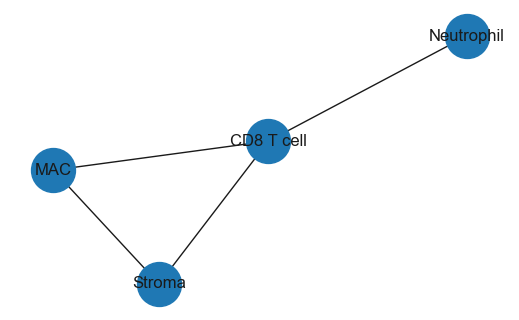

motif_id: 3522784716, hash_id: -7428170179511166437


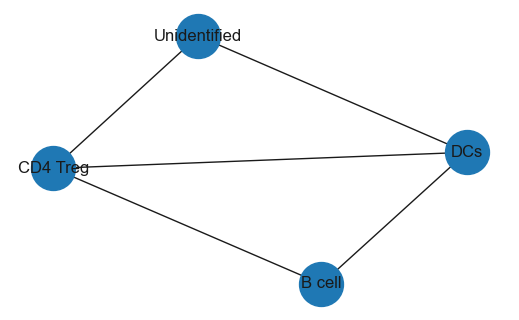

motif_id: 20202011980, hash_id: 4092891317731859338


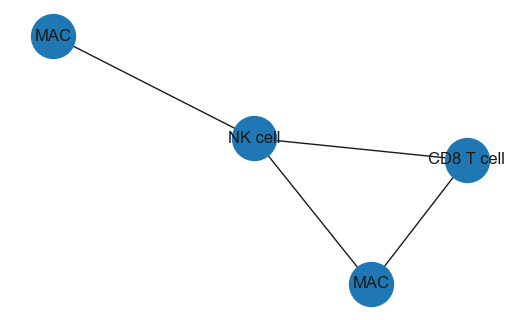

motif_id: 11561745772, hash_id: 3341299229835211946


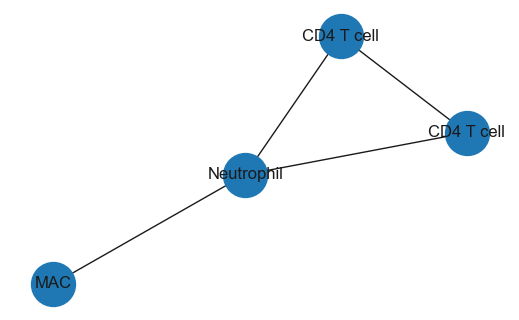

motif_id: 1672625548, hash_id: -8334768063605862937


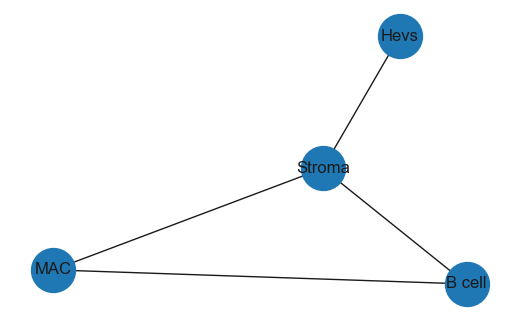

motif_id: 12110603532, hash_id: 2856578561211090970


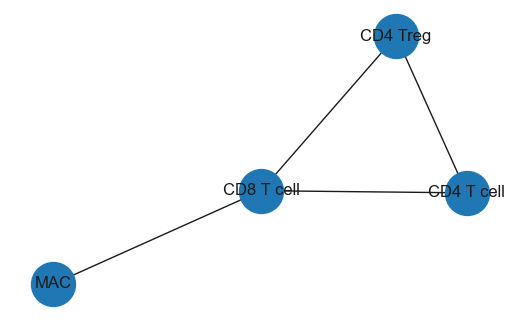

motif_id: 1639021836, hash_id: 7476495471272693903


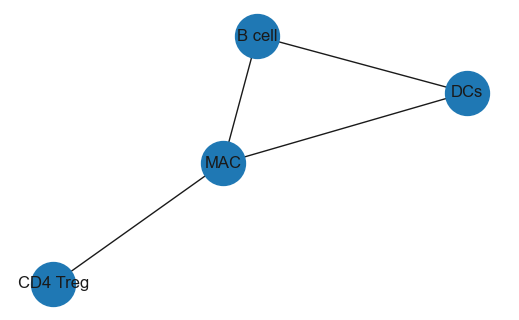

motif_id: 1677351212, hash_id: -3276004159126218973


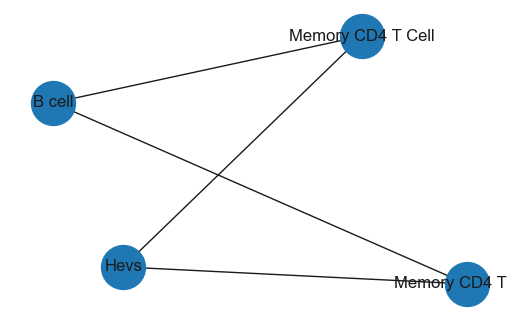

motif_id: 11583232364, hash_id: -3798811191137981739


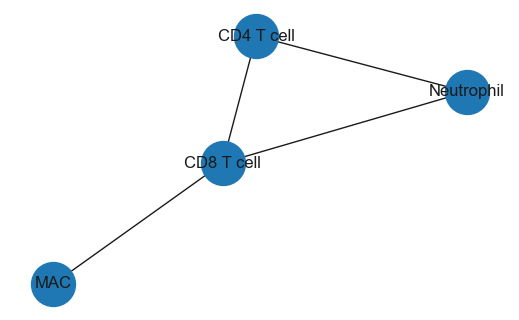

motif_id: 2454267148, hash_id: -2785496978450312591


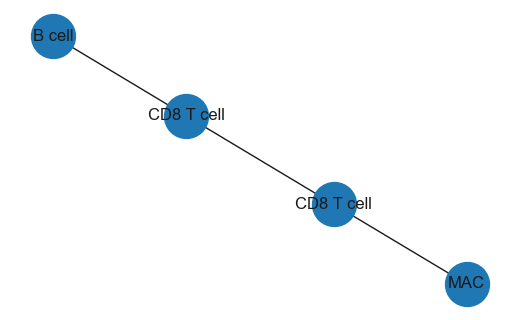

motif_id: 4880694732, hash_id: 6501729852448164872


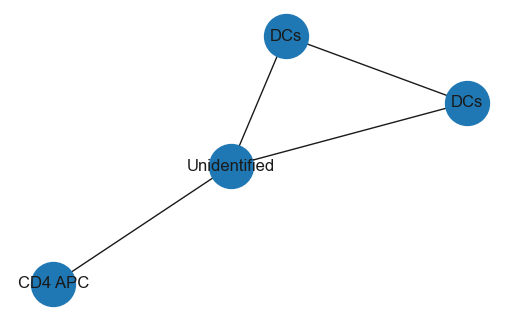

motif_id: 15901249932, hash_id: -2937209521203962343


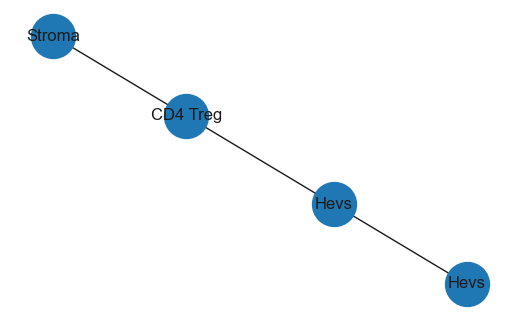

motif_id: 11075202540, hash_id: -2419085700876409031


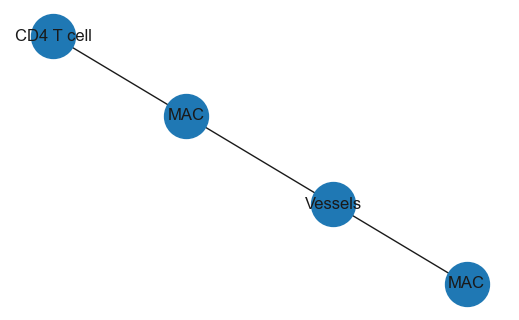

motif_id: 17763644908, hash_id: -3945035406512623651


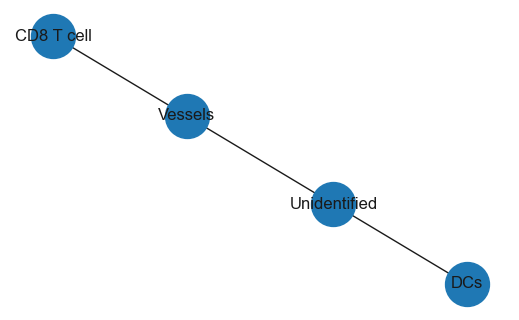

motif_id: 2961208588, hash_id: 5322849665145976878


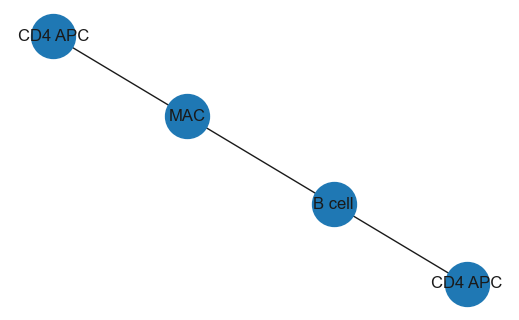

motif_id: 20748339660, hash_id: 7522159845133462507


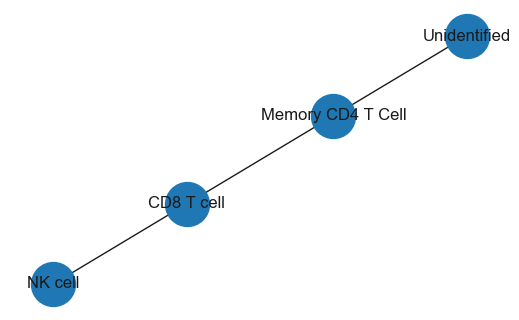

motif_id: 16417793484, hash_id: 7779624149145954569


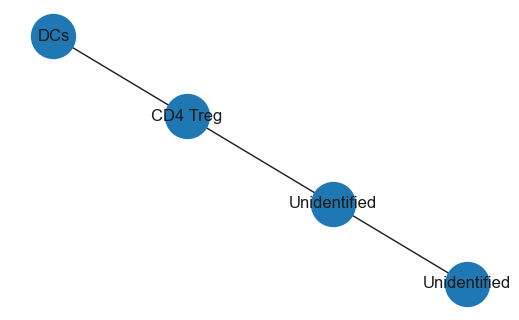

In [39]:
from cism.vis import draw

for idx, row in ratio_gain_results.iterrows():
    hash_id = ratio_gain_results.loc[idx].hash
    motifs = cell_identity_to_motif_hash[ratio_gain_results.loc[idx].hash]
    for motif_id in motifs:
        print(f'motif_id: {motif_id}, hash_id: {hash_id}')
        target_motif = cism_4_nodes.motifs_dataset[cism_4_nodes.motifs_dataset.ID == motif_id].iloc[0].motif
        target_motif = helpers.string_base64_pickle(target_motif)
        draw.draw_motif(target_motif, cells_type=cells_type)